In [15]:
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error


import numpy as np
np.random.seed(42)
import random

# Устанавливаем seed для воспроизводимости результатов
np.random.seed(42)

# Генерируем датасет
n = 1000
X, Y = make_classification(n_samples=n, n_features=5, n_redundant=0, n_classes=2, random_state=42)

# Преобразуем тип данных в np.float32 и np.int32 для X и Y соответственно
X = X.astype(np.float32)
Y = Y.astype(np.int32)

# Разделяем данные на обучающий и тестовый наборы
train_x, test_x, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

# Классы

# Сеть

In [16]:
# Генерируем датасет
n = 1000
X, Y = make_classification(n_samples=n, n_features=5, n_redundant=0, n_classes=2, random_state=42)

# Преобразуем тип данных в np.float32 и np.int32 для X и Y соответственно
X = X.astype(np.float32)
Y = Y.astype(np.int32)

# Разделяем данные на обучающий и тестовый наборы
train_x, test_x, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [3]:
class Net:
    def __init__(self):
        self.layers = []
        self.train_loss_history = []
        self.test_loss_history = []

    class Linear:
        def __init__(
                self,
                nin,
                nout,
                momentum:float=0.9
            ):
            np.random.seed(42)
            self.W = np.random.randn(nin, nout) # упростим инициализацию весов
            self.b = np.ones((1, nout)) # упростим инициализацию байесов
            self.dW = np.random.randn(self.W.shape[0], self.W.shape[1]) # можно не инициализировать будет далее
            self.db = np.random.randn(self.b.shape[0], self.b.shape[1]) # можно не инициализировать будет далее
            self.previous_dW = np.zeros_like(self.W) # для момента
            self.previous_db = np.zeros_like(self.b) # для момента
            self.momentum = momentum
            self.x = None


        def forward(self, x):
            self.x = x
            return np.dot(x, self.W) + self.b

        def backward(self, dz):
            dx = np.dot(dz, self.W.T)
            self.dW = np.dot(self.x.T, dz)
            self.db = dz.sum(axis=0)
            return dx

        def update(self, lr):
            self.W -= lr * self.dW
            self.b -= lr * self.db

    class Softmax:
        def forward(self,z):
            self.z = z
            zmax = z.max(axis=1,keepdims=True)
            expz = np.exp(z-zmax)
            Z = expz.sum(axis=1,keepdims=True)
            return expz / Z
        def backward(self,dp):
            p = self.forward(self.z)
            pdp = p * dp
            return pdp - p * pdp.sum(axis=1, keepdims=True)
        
    class CrossEntropyLoss:
        def forward(self,p,y):
            self.p = p
            self.y = y
            p_of_y = p[np.arange(len(y)), y]
            log_prob = np.log(p_of_y)
            return -log_prob.mean()
        
        def backward(self):
            dlog_softmax = np.zeros_like(self.p)
            dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
            return dlog_softmax / self.p

    class Sigmoid:
        def forward(self, z):
            self.z = z
            return 1 / (1 + np.exp(-z))

        def backward(self, dp):
            sig = self.forward(self.z)
            return dp * sig * (1 - sig)
        

    class ReLU:
        def forward(self, z):
            self.z = z
            return np.maximum(0, z)

        def backward(self, dp):
            dz = np.where(self.z > 0, 1, 0)
            return dp * dz

        
    class BinaryCrossEntropyLoss:
        def forward(self, p, y):
            self.p = p
            self.y = y
            self.y_binary = np.zeros((len(y), 2))
            self.y_binary[np.arange(len(y)), y] = 1
            return -np.mean(self.y_binary * np.log(p) + (1 - self.y_binary) * np.log(1 - p))
                
        def backward(self):
            return (self.p - self.y_binary) / self.p.shape[0]
        
    class MeanSquaredError:
        def forward(self, p, y):
            self.p = p
            self.y = y
            return np.mean((p - y) ** 2)

        def backward(self):
            return (2 * (self.p - self.y)) / self.p.shape[0]


    class MeanAbsoluteError:
        def forward(self, p, y):
            self.p = p
            self.y = y
            return np.mean(np.abs(p - y))

        def backward(self):
            return np.sign(self.p - self.y) / self.p.shape[0]
    
    def add(self, layer_type, *args, **kwargs):
        if layer_type == 'Linear':
            self.layers.append(self.Linear(*args, **kwargs))
        elif layer_type == 'Softmax':
            self.layers.append(self.Softmax(*args, **kwargs))
        elif layer_type == 'Sigmoid':
            self.layers.append(self.Sigmoid(*args, **kwargs))
        elif layer_type == 'ReLU':  # Добавляем блок для слоя ReLU
            self.layers.append(self.ReLU(*args, **kwargs))
        else:
            raise ValueError("Unknown layer type")
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for layer in self.layers:
            if 'update' in layer.__dir__():
                layer.update(lr)

    def update_momentum_sgd(self, lr):
        for layer in self.layers:
            if 'update' in layer.__dir__():
                dW = layer.dW
                db = layer.db
                # Add momentum to the update
                dW = layer.momentum * layer.previous_dW + (1 - layer.momentum) * dW
                db = layer.momentum * layer.previous_db + (1 - layer.momentum) * db
                # Update weights and biases
                layer.update(lr)
                # Update previous gradients for the next iteration
                layer.previous_dW = dW
                layer.previous_db = db

    def fit(self,
            task_type:str,
            epochs:int,
            train_dataset:list,
            loss_f,
            lr,
            optimizer:str,
            batch_size:int=None,
            val_dataset:list=None
        ):

        self.task_type = task_type
        
        for epoch in range(1, epochs+1):            
            if optimizer == 'sgd':
                for sample in range(len(train_dataset[0])):
                    random_sample = np.random.randint(0, len(train_dataset[0]))
                    xb = train_dataset[0][random_sample:random_sample+1]
                    yb = train_dataset[1][random_sample:random_sample+1]
                    # forward pass
                    p = self.forward(xb)
                    # backward pass
                    loss = loss_f.forward(p, np.array(yb).reshape(-1))
                    dp = loss_f.backward()  # передаем прогнозы и метки в метод backward
                    # if self.task_type == 'regression':
                    #     dp = dp[0].reshape(-1,1)
                    dz = self.backward(dp)
                    # update
                    self.update(lr)
            elif optimizer == 'minibatch_sgd':
                for batch in range(0, len(train_dataset[0]), batch_size):
                    random_sample = np.random.randint(0, len(train_dataset[0]))
                    xb = train_dataset[0][random_sample:random_sample+batch_size]
                    yb = train_dataset[1][random_sample:random_sample+batch_size] 
                    # forward pass
                    p = self.forward(xb)
                    # backward pass
                    loss = loss_f.forward(p, np.array(yb).reshape(-1))
                    dp = loss_f.backward()  # передаем прогнозы и метки в метод backward
                    if self.task_type == 'regression':
                        dp = dp.mean(axis=1).reshape(-1,1)
                    dz = self.backward(dp)
                    # update
                    self.update(lr)
            elif optimizer == 'momentum_sgd':
                for batch in range(0, len(train_dataset[0]), batch_size):
                    random_sample = np.random.randint(0, len(train_dataset[0]))
                    xb = train_dataset[0][random_sample:random_sample+batch_size]
                    yb = train_dataset[1][random_sample:random_sample+batch_size]

                    # forward pass
                    p = self.forward(xb)

                    # backward pass
                    loss = loss_f.forward(p, np.array(yb).reshape(-1))
                    dp = loss_f.backward()
                    if self.task_type == 'regression':
                        dp = dp.mean(axis=1).reshape(-1,1)
                    dz = self.backward(dp)

                    # update
                    self.update_momentum_sgd(lr)
            elif optimizer == 'gd':
                xb = train_dataset[0]
                yb = train_dataset[1]
                # forward pass
                p = self.forward(xb)
                # backward pass
                loss = loss_f.forward(p, np.array(yb).reshape(-1))
                dp = loss_f.backward()  # передаем прогнозы и метки в метод backward
                if self.task_type == 'regression':
                        dp = dp.mean(axis=1).reshape(-1,1)
                dz = self.backward(dp)
                # update
                self.update(lr)

            train_loss = self.get_loss(
                x=train_dataset[0],
                y=train_dataset[1],
                loss_f=loss_f
            )
            self.train_loss_history.append(train_loss)
            print(f"Epoch: {epoch}")
            print(f"train_loss = {train_loss:.4f}")
            if val_dataset:
                test_loss = self.get_loss(
                    x=val_dataset[0],
                    y=val_dataset[1],
                    loss_f=loss_f
                )
                self.test_loss_history.append(test_loss)
                print(f"test_loss = {test_loss:.4f}")
            print('****************************')

            

                    
    def get_loss(self, x, y, loss_f):
        p = self.forward(x)  # Прямой проход через сеть для получения предсказаний
        l = loss_f.forward(p, np.array(y).reshape(-1))  # Вычисление потерь с помощью loss_f
        return l
    
    def evaluate(self, x, y):
        if self.task_type == 'regression':
            y = np.array(y).reshape(-1)
            pred = self.predict(x)
            r2 = r2_score(y, pred)  # Вычисление коэффициента детерминации
            mse = mean_squared_error(y, pred)  # Вычисление среднеквадратичной ошибки
            mae = mean_absolute_error(y, pred)  # Вычисление средней абсолютной ошибки
            mape = np.mean(np.abs((y - pred) / y)) * 100  # Вычисление средней абсолютной процентной ошибки
            return r2, mse, mae, mape
        elif self.task_type == 'classification':
            probas = self.forward(x)  # Прямой проход через сеть для получения вероятностей
            pred = np.argmax(probas, axis=1)  # Преобразование вероятностей в предсказанные классы
            acc = round(accuracy_score(y, pred, normalize=True), 4)  # Вычисление средней точности
            return acc
        
    def predict(self, x):
        if self.task_type == 'regression':
            return self.forward(x)  # Прямой проход через сеть для получения прогнозов
        elif self.task_type == 'classification':
            probas = self.forward(x)  # Прямой проход через сеть для получения вероятностей
            pred = np.argmax(probas, axis=1)  # Выбор класса с наибольшей вероятностью
            return pred
        
    def print_loss_history(self):
        plt.plot(self.train_loss_history, label='loss_train')
        plt.plot(self.test_loss_history, label='loss_test')
        plt.xlabel('Iteration')
        plt.ylabel('Loss metric')
        plt.legend(fontsize=10)
        plt.show()



# ---

In [17]:
# Sigmoid
net = Net()
net.add('Linear', train_x.shape[1], 2, momentum=0.2)
net.add('Sigmoid')
net.add('Linear', 2, 2)
net.add('Sigmoid')
loss = net.BinaryCrossEntropyLoss()

net.fit(
    task_type='classification',
    train_dataset=[train_x, train_labels],
    val_dataset=[test_x, test_labels],
    loss_f=loss,
    epochs=200,
    batch_size=4,
    lr=0.1,
    optimizer='minibatch_sgd'
)

Epoch: 1
train_loss = 0.7063
test_loss = 0.6997
****************************
Epoch: 2
train_loss = 0.6673
test_loss = 0.6570
****************************
Epoch: 3
train_loss = 0.6291
test_loss = 0.6176
****************************
Epoch: 4
train_loss = 0.5785
test_loss = 0.5691
****************************
Epoch: 5
train_loss = 0.5197
test_loss = 0.5122
****************************
Epoch: 6
train_loss = 0.4652
test_loss = 0.4627
****************************
Epoch: 7
train_loss = 0.4254
test_loss = 0.4263
****************************
Epoch: 8
train_loss = 0.4009
test_loss = 0.4046
****************************
Epoch: 9
train_loss = 0.3841
test_loss = 0.3902
****************************
Epoch: 10
train_loss = 0.3723
test_loss = 0.3800
****************************
Epoch: 11
train_loss = 0.3639
test_loss = 0.3742
****************************
Epoch: 12
train_loss = 0.3567
test_loss = 0.3684
****************************
Epoch: 13
train_loss = 0.3519
test_loss = 0.3662
************************

In [18]:
accuracy_score(test_labels, net.predict(test_x))

0.845

# Testing

## Iris

In [21]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Загрузка датасета Ирис
iris = load_iris()
X, y = iris.data, iris.target

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Кодирование меток классов
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [22]:
net = Net()
net.add('Linear', X_train_scaled.shape[1], 4, momentum=0.9)
net.add('ReLU')
net.add('Linear', 4, 10, momentum=0.9)
net.add('ReLU')
net.add('Linear', 10, len(np.unique(y_train_encoded)), momentum=0.9)
net.add('Softmax')
loss = net.CrossEntropyLoss()

net.fit(
    task_type='classification',
    train_dataset=[X_train_scaled, y_train_encoded],
    val_dataset=[X_test_scaled, y_test_encoded],
    loss_f=loss,
    epochs=100,
    batch_size=12,
    lr=2e-3,
    optimizer='momentum_sgd'
    # optimizer='sgd'
)

Epoch: 1
train_loss = 4.3535
test_loss = 4.5011
****************************
Epoch: 2
train_loss = 3.6368
test_loss = 3.6920
****************************
Epoch: 3
train_loss = 2.9451
test_loss = 2.9356
****************************
Epoch: 4
train_loss = 2.3730
test_loss = 2.3466
****************************
Epoch: 5
train_loss = 2.0133
test_loss = 1.9673
****************************
Epoch: 6
train_loss = 1.7751
test_loss = 1.7251
****************************
Epoch: 7
train_loss = 1.5823
test_loss = 1.5233
****************************
Epoch: 8
train_loss = 1.4514
test_loss = 1.3851
****************************
Epoch: 9
train_loss = 1.3581
test_loss = 1.2826
****************************
Epoch: 10
train_loss = 1.2882
test_loss = 1.2079
****************************
Epoch: 11
train_loss = 1.2129
test_loss = 1.1339
****************************
Epoch: 12
train_loss = 1.1434
test_loss = 1.0647
****************************
Epoch: 13
train_loss = 1.0848
test_loss = 0.9969
************************

In [24]:
# Оценка производительности нейросети на тестовых данных
test_loss = net.get_loss(X_test_scaled, y_test_encoded, loss)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.1469


In [25]:
net.evaluate(X_test_scaled, y_test_encoded)

0.9667

In [26]:
net.predict([5.1, 3.5, 1.4, 0.2])

array([0], dtype=int64)

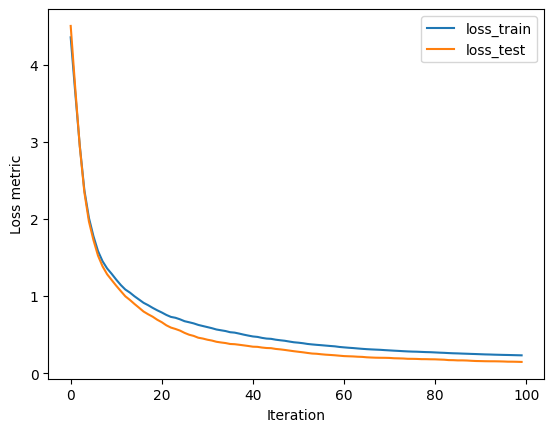

In [27]:
net.print_loss_history()

## MNIST

In [34]:
from keras.datasets import mnist

# Загрузка данных
(train_x, train_y), (test_x, test_y) = mnist.load_data()

# Предварительная обработка данных (например, нормализация)
train_x = train_x.reshape(train_x.shape[0], -1) / 255.0
test_x = test_x.reshape(test_x.shape[0], -1) / 255.0

# Разделение на тренировочный и тестовый наборы
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

ModuleNotFoundError: No module named 'tensorflow.python'

In [33]:
import matplotlib.pyplot as plt

# Вывод первого изображения
plt.imshow(train_x[150].reshape(28, 28), cmap='gray')
plt.title(f'Label: {train_y[0]}')
plt.axis('off')
plt.show()

ValueError: cannot reshape array of size 5 into shape (28,28)

In [25]:
# Создание и обучение нейронной сети
net = Net()
net.add('Linear', train_x.shape[1], 128, momentum=0.9)
net.add('ReLU')
net.add('Linear', 128, 10)
net.add('Softmax')
loss = net.CrossEntropyLoss()

net.fit(
    task_type='classification',
    train_dataset=[train_x, train_y],
    val_dataset=[val_x, val_y],
    loss_f=loss,
    epochs=3,
    batch_size=32,
    lr=0.01,
    optimizer='momentum_sgd'
)

Epoch: 1
train_loss = 3.7955
test_loss = 3.8999
****************************
Epoch: 2
train_loss = 2.4668
test_loss = 2.6235
****************************
Epoch: 3
train_loss = 1.8432
test_loss = 2.0642
****************************


In [12]:
net.evaluate(val_x, val_y)

NameError: name 'val_x' is not defined

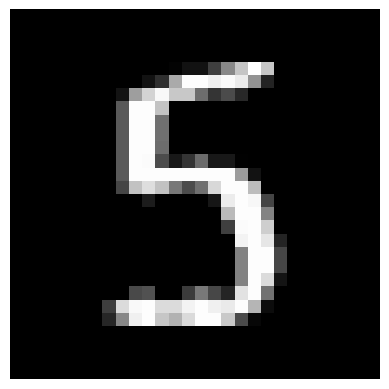

Истинное число: 5
Предсказанное моделью: 5


In [27]:
plt.imshow(val_x[130].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

print(f'Истинное число: {val_y[130]}')
print(f"Предсказанное моделью: {net.predict(val_x[130])[0]}")

In [13]:
for i in range(10):
    n = np.random.randint(len(val_x))
    print(f"True: {val_y[n]}; Pred: {net.predict(val_x[n])[0]}")

NameError: name 'np' is not defined

## Boston

In [35]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Загрузка данных
data = pd.read_csv('BostonHousing.csv')

# Разделение на признаки и метки
X = data.drop('medv', axis=1)
y = data['medv']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [36]:
# Создание и обучение нейронной сети
net = Net()
net.add('Linear', X_train.shape[1], 32, momentum=0.9)
net.add('ReLU')
net.add('Linear', 32, 16, momentum=0.9)
net.add('ReLU')
net.add('Linear', 16, 1, momentum=0.9)
loss = net.MeanSquaredError()

net.fit(
    task_type='regression',
    train_dataset=[X_train, y_train],
    val_dataset=[X_test, y_test],
    loss_f=loss,
    epochs=5000,
    batch_size=32,
    lr=2e-4,
    optimizer='momentum_sgd'
    # optimizer='gd'
    # optimizer='sgd'
)

Epoch: 1
train_loss = 243.1649
test_loss = 234.7462
****************************
Epoch: 2
train_loss = 164.1303
test_loss = 151.1816
****************************
Epoch: 3
train_loss = 139.9840
test_loss = 130.5259
****************************
Epoch: 4
train_loss = 130.1047
test_loss = 124.0293
****************************
Epoch: 5
train_loss = 123.1679
test_loss = 118.4679
****************************
Epoch: 6
train_loss = 117.9689
test_loss = 113.7348
****************************
Epoch: 7
train_loss = 113.8305
test_loss = 109.6212
****************************
Epoch: 8
train_loss = 111.6598
test_loss = 106.8034
****************************
Epoch: 9
train_loss = 110.4366
test_loss = 108.3845
****************************
Epoch: 10
train_loss = 107.6747
test_loss = 103.5663
****************************
Epoch: 11
train_loss = 107.5188
test_loss = 104.3760
****************************
Epoch: 12
train_loss = 105.7457
test_loss = 100.9406
****************************
Epoch: 13
train_loss = 10

In [38]:
n = 78
print(net.predict(X_scaled[n]))
print(y.iloc[n])

n = 436
print(net.predict(X_scaled[n]))
print(y.iloc[n])

n = 112
print(net.predict(X_scaled[n]))
print(y.iloc[n])

[[22.11881562]]
21.2
[[22.75336555]]
9.6
[[23.55754632]]
18.8


In [39]:
net.predict([0,0,2,0,0,0,0.2,0,0,0,0,0.3,0.1])

array([[21.53328008]])

In [40]:
net.evaluate(X_test, y_test)

(-0.007036528680711918,
 73.84979842879568,
 6.223938633316221,
 39.31507465539874)